In [28]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import optuna

# Импорт моделей
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier # <--- Оставлено

# Импорт метрик для оценки
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Импорт для разделения выборки
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Настройки для отображения Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [34]:
# Загрузка данных

# Путь к папке с файлами
data_path = '../data/features_final/'

# Загрузка индивидуальных файлов (используем SBER и ROSN как пример)
try:
    sber_df = pd.read_csv(os.path.join(data_path, 'SBER_final.csv'))
    rosn_df = pd.read_csv(os.path.join(data_path, 'ROSN_final.csv'))
    print(f"SBER_final.csv загружен: {sber_df.shape}")
    print(f"ROSN_final.csv загружен: {rosn_df.shape}")
except FileNotFoundError as e:
    print(f"Ошибка при загрузке индивидуальных файлов: {e}. Убедитесь, что файлы существуют.")
    # Создаем пустые датафреймы, если файлы не найдены, чтобы код ниже не падал
    sber_df = pd.DataFrame()
    rosn_df = pd.DataFrame()

# Объединение всех файлов из папки
all_files = glob.glob(os.path.join(data_path, "*_final.csv"))

if not all_files:
    print(f"В папке {data_path} не найдено файлов *_final.csv для объединения.")
    all_stocks_df = pd.DataFrame() # Создаем пустой датафрейм
else:
    df_list = []
    for filename in all_files:
        try:
            df_temp = pd.read_csv(filename, index_col=None, header=0)
            df_list.append(df_temp)
        except Exception as e:
            print(f"Ошибка при чтении файла {filename}: {e}")
    
    if df_list:
        all_stocks_df = pd.concat(df_list, axis=0, ignore_index=True)
        print(f"\nВсего {len(df_list)} файлов объединено в all_stocks_df.")
        print(f"Размер объединенного датасета: {all_stocks_df.shape}")
        # print("\nПервые 5 строк объединенного датасета:")
        # print(all_stocks_df.head())
        # print("\nИнформация о типах данных и пропусках в объединенном датасете:")
        # all_stocks_df.info()
    else:
        print("Не удалось загрузить ни один файл для объединения.")
        all_stocks_df = pd.DataFrame()

SBER_final.csv загружен: (1599, 138)
ROSN_final.csv загружен: (1599, 158)

Всего 252 файлов объединено в all_stocks_df.
Размер объединенного датасета: (346177, 158)


In [36]:
# Определение списков признаков и целевых переменных

# Колонки, которые не являются ни признаками, ни стандартными целями
non_feature_cols = ['date', 'SECID'] 

# --- Компоненты признаков ---
price_volume_cols = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOLUME', 'WAPRICE']
ma_cols = ['SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'SMA_50', 'EMA_50', 'SMA_200', 'EMA_200']
oscillator_cols = [
    'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width',
    'STOCH_K', 'STOCH_D', 'ATR', 'VWAP', 'OBV', 'OBV_MA', 'Williams_%R', 'Momentum',
    'Plus_DI', 'Minus_DI', 'ADX', 'MFI', 'PVO', 'PVO_Signal', 'PVO_Hist', 'Chaikin_AD',
    'Chaikin_Oscillator', 'CCI', 'EMV', 'A/D_Line', 'Bull_Power', 'Bear_Power', 'TEMA'
]
fundamental_cols = [
    'Assets_q', 'Assets_y', 'CAPEX_q', 'CAPEX_y', 'Cash_q', 'Cash_y', 'Debt_q', 'Debt_y',
    'DividendsPaid_q', 'DividendsPaid_y', 'EBITDA_q', 'EBITDA_y', 'Equity_q', 'Equity_y',
    'NetDebt_q', 'NetDebt_y', 'NetProfit_q', 'NetProfit_y', 'OperatingCashFlow_q', 'OperatingCashFlow_y',
    'OperatingExpenses_q', 'OperatingExpenses_y', 'OperatingProfit_q', 'OperatingProfit_y',
    'Revenue_q', 'Revenue_y'
]
macro_index_cols = [
    'BRENT_CLOSE', 'KEY_RATE', 'CPI', 'USD_RUB', 'EUR_RUB', 'CNY_RUB', 'KZT_RUB', 'TRY_RUB', 'GOLD', 'SILVER', 'NATURAL_GAS_CLOSE',
    'MRBC', 'RTSI', 'MCXSM', 'IMOEX', 'MOEXBC', 'MOEXBMI', 'MOEXCN', 'MOEXIT', 
    'MOEXRE', 'MOEXEU', 'MOEXFN', 'MOEXINN', 'MOEXMM',
    'MOEXOG', 'MOEXTL', 'MOEXTN', 'MOEXCH'
]
relative_coeff_cols = [
    'ROE_y', 'ROA_y', 'EBITDA_Margin_y', 'NetProfit_Margin_y', 'Debt_Equity_q', 'Debt_Equity_y',
    'NetDebt_EBITDA_y_q', 'NetDebt_EBITDA_y_y', 'EPS_y', 'BVPS_q', 'BVPS_y', 'SPS_y',
    'PE_y', 'PB_q', 'PB_y', 'PS_y', 'EV_EBITDA_y'
]
X_media_features = [
    'score_blog', 'score_blog_roll_avg_15', 'score_blog_roll_avg_50',
    'Index_MOEX_blog_score', 'Avg_Other_Indices_blog_score',
    'Avg_Other_Indices_blog_score_roll_avg_15', 'Avg_Other_Indices_blog_score_roll_avg_50', 
    'score_news', 'score_news_roll_avg_15', 'score_news_roll_avg_50',
    'Index_MOEX_news_score', 'Avg_Other_Indices_news_score', 
    'Avg_Other_Indices_news_score_roll_avg_15', 'Avg_Other_Indices_news_score_roll_avg_50'
]

# --- Основные наборы признаков ---
# 1. Базовый набор (все, кроме медиа)
X_base_features = price_volume_cols + ma_cols + oscillator_cols + fundamental_cols + macro_index_cols + relative_coeff_cols

# 2. Расширенный набор (базовый + медиа)
X_extended_features = X_base_features + X_media_features

# 3. Технические индикаторы + Макро (Базовый - Фундаментальные - Относительные коэффициенты)
# (media_features не входят в X_base_features, поэтому их отдельно убирать не надо из X_base_features)
X_TECH_MACRO_features = list(set(price_volume_cols + ma_cols + oscillator_cols + macro_index_cols))

# 4. Только технические индикаторы (из цен, средних, осцилляторов)
# (X_TECH_MACRO_features - Макро)
X_TECH_ONLY_features = list(set(price_volume_cols + ma_cols + oscillator_cols))


# --- Целевые переменные ---
y_reg_targets = ['target_1d', 'target_3d', 'target_7d', 'target_30d', 'target_180d', 'target_365d']
y_clf_binary_targets = ['target_1d_binary', 'target_3d_binary', 'target_7d_binary', 'target_30d_binary', 'target_180d_binary', 'target_365d_binary']

# Колонки, предназначенные для записи будущих предсказаний моделей
existing_prediction_cols = [
    'target_1d_pred', 'target_3d_pred', 'target_7d_pred', 'target_30d_pred', 'target_180d_pred', 'target_365d_pred'
    'target_1d_binary_pred', 'target_3d_binary_pred', 'target_7d_binary_pred',
    'target_30d_binary_pred', 'target_180d_binary_pred', 'target_365d_binary_pred'
]

print(f"Количество базовых признаков (X_base): {len(X_base_features)}")
print(f"Количество медиа-признаков (X_media): {len(X_media_features)}")
print(f"Количество расширенных признаков (X_extended): {len(X_extended_features)}")
print(f"Количество признаков в наборе Тех.Индикаторы+Макро (X_TECH_MACRO): {len(X_TECH_MACRO_features)}")
print(f"Количество признаков в наборе Только Тех.Индикаторы (X_TECH_ONLY): {len(X_TECH_ONLY_features)}")

print(f"\nЦелевые для регрессии: {y_reg_targets}")
print(f"Целевые для классификации: {y_clf_binary_targets}")
print(f"Колонки для будущих предсказаний (не проверяются на наличие в исходных CSV): {existing_prediction_cols}")

# Колонки, которые ДОЛЖНЫ БЫТЬ в CSV для корректной работы скрипта:
required_cols_for_script = list(set(
    non_feature_cols + 
    price_volume_cols + ma_cols + oscillator_cols + fundamental_cols + macro_index_cols + relative_coeff_cols + # компоненты X_base
    X_media_features + # компоненты X_extended
    y_reg_targets + y_clf_binary_targets
))

if not all_stocks_df.empty:
    missing_required_cols_in_loaded_df = []
    for col in required_cols_for_script:
        if col not in all_stocks_df.columns:
            missing_required_cols_in_loaded_df.append(col)
            
    if missing_required_cols_in_loaded_df:
        print(f"\nВНИМАНИЕ: Следующие НЕОБХОДИМЫЕ для работы скрипта колонки НЕ найдены в загруженном all_stocks_df: {set(missing_required_cols_in_loaded_df)}")
        print("Это может означать, что CSV файлы не содержат всех нужных признаков или целевых переменных, либо есть опечатки в именах.")
        print("Пожалуйста, проверьте ваши CSV файлы и определения колонок в Ячейке 3.")
        if 'NetDebt_EBITDA_y_y' in missing_required_cols_in_loaded_df:
            print("-> Среди отсутствующих есть 'NetDebt_EBITDA_y_y'. Это важный базовый признак. Проверьте его наличие и название в CSV.")
    else:
        print("\nВсе НЕОБХОДИМЫЕ для обучения колонки (идентификаторы, признаки, актуальные таргеты) присутствуют в all_stocks_df.")
else:
    print("\nПроверка необходимых колонок не проводилась, так как all_stocks_df пуст (данные еще не загружены или не найдены).")

print("\nСписки признаков (включая новые сценарии X_TECH_MACRO, X_TECH_ONLY) и целевых переменных определены.")

Количество базовых признаков (X_base): 118
Количество медиа-признаков (X_media): 14
Количество расширенных признаков (X_extended): 132
Количество признаков в наборе Тех.Индикаторы+Макро (X_TECH_MACRO): 75
Количество признаков в наборе Только Тех.Индикаторы (X_TECH_ONLY): 47

Целевые для регрессии: ['target_1d', 'target_3d', 'target_7d', 'target_30d', 'target_180d', 'target_365d']
Целевые для классификации: ['target_1d_binary', 'target_3d_binary', 'target_7d_binary', 'target_30d_binary', 'target_180d_binary', 'target_365d_binary']
Колонки для будущих предсказаний (не проверяются на наличие в исходных CSV): ['target_1d_pred', 'target_3d_pred', 'target_7d_pred', 'target_30d_pred', 'target_180d_pred', 'target_365d_predtarget_1d_binary_pred', 'target_3d_binary_pred', 'target_7d_binary_pred', 'target_30d_binary_pred', 'target_180d_binary_pred', 'target_365d_binary_pred']

Все НЕОБХОДИМЫЕ для обучения колонки (идентификаторы, признаки, актуальные таргеты) присутствуют в all_stocks_df.

Списки

In [37]:
# Вспомогательная функция для метрики Sgn Acc

def sign_accuracy(y_true, y_pred):
    """
    Рассчитывает точность предсказания знака.
    1, если знаки совпадают (или оба 0), 0 иначе.
    """
    y_true_sign = np.sign(y_true)
    y_pred_sign = np.sign(y_pred)
    return np.mean(y_true_sign == y_pred_sign)

print("Функция sign_accuracy определена.")

Функция sign_accuracy определена.


In [38]:
def train_evaluate_model(df, ticker_name, target_col, model_type, feature_set_name, current_feature_list, random_state=42):
    """
    Обучает и оценивает модель на ЗАДАННОМ списке признаков.
    Обрабатывает NaN в целевой переменной.
    Использует TimeSeriesSplit для разделения данных (или последние 15% для теста, если данных мало).
    Не заполняет NaN в признаках (LightGBM, XGBoost и CatBoost обработают их).
    """
    results = {
        'Ticker': ticker_name,
        'TargetVariable': target_col,
        'ModelType': model_type,
        'FeatureSet': feature_set_name,
        'NumTrainSamples': 0,
        'NumTestSamples': 0,
        'MAE': np.nan, 'RMSE': np.nan, 'R2': np.nan, 'Sgn_acc': np.nan,
        'Accuracy': np.nan, 'Precision': np.nan, 'Recall': np.nan, 'F1': np.nan, 'ROC_AUC': np.nan
    }

    final_feature_list_for_df = [f for f in current_feature_list if f in df.columns]
    
    if len(final_feature_list_for_df) < len(current_feature_list):
        missing_from_list = set(current_feature_list) - set(final_feature_list_for_df)
        print(f"Предупреждение для {ticker_name}, таргет {target_col}, набор {feature_set_name}: \\\n              Некоторые признаки из заданного списка {feature_set_name} отсутствуют в DataFrame: {missing_from_list}.\\\n              Будут использованы только доступные: {len(final_feature_list_for_df)} из {len(current_feature_list)}.")

    if not final_feature_list_for_df:
        print(f"КРИТИЧЕСКОЕ ПРЕДУПРЕЖДЕНИЕ для {ticker_name}, таргет {target_col}, набор {feature_set_name}: \\\n              Ни один из признаков из списка {feature_set_name} не найден в DataFrame. Пропуск этого сценария.")
        results['MAE'] = 'NoFeaturesInDf' if model_type.endswith('Regressor') else np.nan
        results['Accuracy'] = 'NoFeaturesInDf' if model_type.endswith('Classifier') else np.nan
        return results

    X = df[final_feature_list_for_df].copy()
    y = df[target_col].copy()

    valid_indices = y.dropna().index
    X = X.loc[valid_indices]
    y = y.loc[valid_indices]

    if X.empty or y.empty or len(X) < 2: 
        print(f"Предупреждение для {ticker_name}, таргет {target_col}, набор {feature_set_name}: После удаления NaN в таргете не осталось данных или их слишком мало ({len(X)}).")
        results['MAE'] = 'NoData' if model_type.endswith('Regressor') else np.nan
        results['Accuracy'] = 'NoData' if model_type.endswith('Classifier') else np.nan
        return results

    if X.shape[1] == 0:
        print(f"Предупреждение для {ticker_name}, таргет {target_col}, набор {feature_set_name}: Не осталось признаков после обработки NaN в таргете.")
        results['MAE'] = 'NoFeaturesPostTargetNaN' if model_type.endswith('Regressor') else np.nan
        results['Accuracy'] = 'NoFeaturesPostTargetNaN' if model_type.endswith('Classifier') else np.nan
        return results

    n_splits_for_ts = 5 
    min_samples_for_tscv = n_splits_for_ts + 1

    if len(X) < min_samples_for_tscv:
        print(f"Предупреждение для {ticker_name}, таргет {target_col}, набор {feature_set_name}: Слишком мало данных ({len(X)}) для TimeSeriesSplit. Используем простой split (~15% тест)." )
        test_sample_size = int(len(X) * 0.15)
        if test_sample_size == 0 and len(X) > 1: test_sample_size = 1
        if len(X) - test_sample_size < 1 or test_sample_size < 1:
            print(f"Предупреждение для {ticker_name}, таргет {target_col}, набор {feature_set_name}: Недостаточно данных для простого разделения.")
            results['MAE'] = 'NoTrainTestData' if model_type.endswith('Regressor') else np.nan
            results['Accuracy'] = 'NoTrainTestData' if model_type.endswith('Classifier') else np.nan
            return results
        train_indices = X.index[:len(X)-test_sample_size]
        test_indices = X.index[len(X)-test_sample_size:]
    else:
        tscv = TimeSeriesSplit(n_splits=n_splits_for_ts)
        all_splits = list(tscv.split(X, y))
        train_indices, test_indices = all_splits[-1] 
        
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    results['NumTrainSamples'] = len(X_train)
    results['NumTestSamples'] = len(X_test)

    if len(X_train) == 0 or len(X_test) == 0:
        print(f"Предупреждение для {ticker_name}, таргет {target_col}, набор {feature_set_name}: Пустой train или test набор.")
        results['MAE'] = 'NoTrainTestData' if model_type.endswith('Regressor') else np.nan
        results['Accuracy'] = 'NoTrainTestData' if model_type.endswith('Classifier') else np.nan
        return results

    model = None
    is_regressor = False
    if model_type == 'LGBMRegressor':
        model = LGBMRegressor(random_state=random_state, verbosity=-1)
        is_regressor = True
    elif model_type == 'XGBRegressor':
        model = XGBRegressor(random_state=random_state)
        is_regressor = True
    elif model_type == 'LGBMClassifier':
        model = LGBMClassifier(random_state=random_state, verbosity=-1)
    elif model_type == 'XGBClassifier':
        model = XGBClassifier(random_state=random_state, eval_metric='logloss' if pd.unique(y_train).size <= 2 else None)
    elif model_type == 'CatBoostRegressor':
        model = CatBoostRegressor(random_state=random_state, verbose=0)
        is_regressor = True
    elif model_type == 'CatBoostClassifier':
        model = CatBoostClassifier(random_state=random_state, verbose=0)
    else:
        raise ValueError(f"Неизвестный тип модели: {model_type}")

    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        if is_regressor:
            results['MAE'] = mean_absolute_error(y_test, y_pred)
            results['RMSE'] = np.sqrt(mean_squared_error(y_test, y_pred))
            results['R2'] = r2_score(y_test, y_pred)
            results['Sgn_acc'] = sign_accuracy(y_test, y_pred)
        else: 
            results['Accuracy'] = accuracy_score(y_test, y_pred)
            results['Precision'] = precision_score(y_test, y_pred, zero_division=0)
            results['Recall'] = recall_score(y_test, y_pred, zero_division=0)
            results['F1'] = f1_score(y_test, y_pred, zero_division=0)
            if hasattr(model, "predict_proba"):
                if len(np.unique(y_test)) <= 2:
                    y_pred_proba = model.predict_proba(X_test)[:, 1]
                    results['ROC_AUC'] = roc_auc_score(y_test, y_pred_proba)
                else: 
                    results['ROC_AUC'] = np.nan
            else: 
                results['ROC_AUC'] = np.nan
                
    except Exception as e:
        print(f"Ошибка при обучении/оценке модели {model_type} для {ticker_name}, таргет {target_col}, набор {feature_set_name}: {e}")
        error_msg_short = str(e).splitlines()[0][:70] 
        if is_regressor: results['MAE'] = f'Error: {error_msg_short}'
        else: results['Accuracy'] = f'Error: {error_msg_short}'

    return results

print("Функция train_evaluate_model обновлена для обработки NaN в TabM.")

Функция train_evaluate_model обновлена для обработки NaN в TabM.


In [39]:
# Запуск цикла исследования

all_results_list = []

dataframes_to_process = {}
if not sber_df.empty: dataframes_to_process['SBER'] = sber_df
if not rosn_df.empty: dataframes_to_process['ROSN'] = rosn_df
if not all_stocks_df.empty: dataframes_to_process['ALL_STOCKS'] = all_stocks_df
else: print("Нет данных для обработки в sber_df, rosn_df или all_stocks_df.")

model_types_reg = ['LGBMRegressor', 'XGBRegressor']
model_types_clf = ['LGBMClassifier', 'XGBClassifier']

# Определяем словарь с наборами признаков для итерации
# Ключ - имя набора (для отчета), Значение - список признаков
feature_set_scenarios = {
    "Base": X_base_features,
    "Extended": X_extended_features,
    "Tech_Macro": X_TECH_MACRO_features,
    "Tech_Only": X_TECH_ONLY_features
}

if not dataframes_to_process:
    print("Нет датафреймов для обработки. Проверьте загрузку данных.")
else:
    print(f"Начинаем исследование для: {list(dataframes_to_process.keys())}")
    print(f"Будут протестированы следующие наборы признаков: {list(feature_set_scenarios.keys())}\n")

    for df_name, current_df in dataframes_to_process.items():
        print(f"--- Обработка датафрейма: {df_name} ---")
        
        for target in y_reg_targets:
            if target not in current_df.columns:
                print(f"Целевая переменная {target} отсутствует в {df_name}. Пропуск.")
                continue
            for model_name in model_types_reg:
                for f_set_name, f_set_list in feature_set_scenarios.items(): # Итерация по словарю наборов признаков
                    print(f"Обучение (Регрессия): {model_name} на {f_set_name} ({len(f_set_list)} признаков) для {target} ({df_name})")
                    results = train_evaluate_model(current_df, df_name, target, model_name, 
                                                   f_set_name, # Имя набора для отчета
                                                   f_set_list  # Список признаков для этого набора
                                                  )
                    all_results_list.append(results)
                    # Выводим одну из ключевых метрик для быстрой проверки
                    print(f"  Результат: MAE={results.get('MAE', 'N/A')}, RMSE={results.get('RMSE', 'N/A')}, R2={results.get('R2', 'N/A')}, Sgn_acc={results.get('Sgn_acc', 'N/A')}")

        for target in y_clf_binary_targets:
            if target not in current_df.columns:
                print(f"Целевая переменная {target} отсутствует в {df_name}. Пропуск.")
                continue
            for model_name in model_types_clf:
                for f_set_name, f_set_list in feature_set_scenarios.items(): # Итерация по словарю наборов признаков
                    print(f"Обучение (Классификация): {model_name} на {f_set_name} ({len(f_set_list)} признаков) для {target} ({df_name})")
                    results = train_evaluate_model(current_df, df_name, target, model_name, 
                                                   f_set_name, # Имя набора для отчета
                                                   f_set_list  # Список признаков для этого набора
                                                  )
                    all_results_list.append(results)
                    # Выводим одну из ключевых метрик для быстрой проверки
                    print(f"  Результат: Acc={results.get('Accuracy', 'N/A')}, F1={results.get('F1', 'N/A')}, ROC_AUC={results.get('ROC_AUC', 'N/A')}")
        print(f"--- Обработка датафрейма {df_name} завершена ---\n")

    results_df = pd.DataFrame(all_results_list)
    print("\n--- Исследование завершено. Итоговая таблица результатов: ---")
    # Убедимся, что все нужные колонки есть перед выводом, или выведем все, что есть
    cols_to_show = ['Ticker', 'TargetVariable', 'ModelType', 'FeatureSet', 'NumTrainSamples', 'NumTestSamples', 
                    'MAE', 'RMSE', 'R2', 'Sgn_acc', 
                    'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
    existing_cols_in_results = [col for col in cols_to_show if col in results_df.columns]
    print(results_df[existing_cols_in_results].head())
    
    results_filename = "market_genius_model_results_v2.csv" # Новое имя файла для новых результатов
    results_df.to_csv(results_filename, index=False)
    print(f"\nРезультаты сохранены в файл: {results_filename}")

    if not results_df.empty:
        print("\nДетали по последним нескольким записям:")
        print(results_df[existing_cols_in_results].tail())

print("\nСкрипт завершил выполнение.")

Начинаем исследование для: ['SBER', 'ROSN', 'ALL_STOCKS']
Будут протестированы следующие наборы признаков: ['Base', 'Extended', 'Tech_Macro', 'Tech_Only']

--- Обработка датафрейма: SBER ---
Обучение (Регрессия): LGBMRegressor на Base (118 признаков) для target_1d (SBER)
Предупреждение для SBER, таргет target_1d, набор Base: \
              Некоторые признаки из заданного списка Base отсутствуют в DataFrame: {'EBITDA_y', 'EBITDA_Margin_y', 'Revenue_q', 'SPS_y', 'PS_y', 'EV_EBITDA_y', 'CAPEX_q', 'Debt_y', 'Debt_Equity_q', 'Revenue_y', 'EBITDA_q', 'CAPEX_y', 'NetDebt_EBITDA_y_y', 'NetDebt_y', 'Debt_q', 'OperatingProfit_y', 'Debt_Equity_y', 'NetDebt_EBITDA_y_q', 'NetProfit_Margin_y', 'NetDebt_q'}.\
              Будут использованы только доступные: 98 из 118.
  Результат: MAE=1.5706137322980258, RMSE=2.145210189145635, R2=-0.48420410938314107, Sgn_acc=0.4732824427480916
Обучение (Регрессия): LGBMRegressor на Extended (132 признаков) для target_1d (SBER)
Предупреждение для SBER, таргет tar

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


  Результат: Acc=0.7368421052631579, F1=0.0, ROC_AUC=nan
Обучение (Классификация): LGBMClassifier на Extended (132 признаков) для target_365d_binary (SBER)
Предупреждение для SBER, таргет target_365d_binary, набор Extended: \
              Некоторые признаки из заданного списка Extended отсутствуют в DataFrame: {'EBITDA_y', 'EBITDA_Margin_y', 'Revenue_q', 'SPS_y', 'PS_y', 'EV_EBITDA_y', 'CAPEX_q', 'Debt_y', 'Debt_Equity_q', 'Revenue_y', 'EBITDA_q', 'CAPEX_y', 'NetDebt_EBITDA_y_y', 'NetDebt_y', 'Debt_q', 'OperatingProfit_y', 'Debt_Equity_y', 'NetDebt_EBITDA_y_q', 'NetProfit_Margin_y', 'NetDebt_q'}.\
              Будут использованы только доступные: 112 из 132.


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


  Результат: Acc=0.5676691729323309, F1=0.0, ROC_AUC=nan
Обучение (Классификация): LGBMClassifier на Tech_Macro (75 признаков) для target_365d_binary (SBER)


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


  Результат: Acc=0.7631578947368421, F1=0.0, ROC_AUC=nan
Обучение (Классификация): LGBMClassifier на Tech_Only (47 признаков) для target_365d_binary (SBER)


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


  Результат: Acc=0.8383458646616542, F1=0.0, ROC_AUC=nan
Обучение (Классификация): XGBClassifier на Base (118 признаков) для target_365d_binary (SBER)
Предупреждение для SBER, таргет target_365d_binary, набор Base: \
              Некоторые признаки из заданного списка Base отсутствуют в DataFrame: {'EBITDA_y', 'EBITDA_Margin_y', 'Revenue_q', 'SPS_y', 'PS_y', 'EV_EBITDA_y', 'CAPEX_q', 'Debt_y', 'Debt_Equity_q', 'Revenue_y', 'EBITDA_q', 'CAPEX_y', 'NetDebt_EBITDA_y_y', 'NetDebt_y', 'Debt_q', 'OperatingProfit_y', 'Debt_Equity_y', 'NetDebt_EBITDA_y_q', 'NetProfit_Margin_y', 'NetDebt_q'}.\
              Будут использованы только доступные: 98 из 118.
  Результат: Acc=0.6353383458646616, F1=0.0, ROC_AUC=nan
Обучение (Классификация): XGBClassifier на Extended (132 признаков) для target_365d_binary (SBER)
Предупреждение для SBER, таргет target_365d_binary, набор Extended: \
              Некоторые признаки из заданного списка Extended отсутствуют в DataFrame: {'EBITDA_y', 'EBITDA_Margin_y', '

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


  Результат: Acc=0.6165413533834586, F1=0.0, ROC_AUC=nan
Обучение (Классификация): XGBClassifier на Tech_Macro (75 признаков) для target_365d_binary (SBER)
  Результат: Acc=0.6165413533834586, F1=0.0, ROC_AUC=nan
Обучение (Классификация): XGBClassifier на Tech_Only (47 признаков) для target_365d_binary (SBER)


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


  Результат: Acc=0.6240601503759399, F1=0.0, ROC_AUC=nan
--- Обработка датафрейма SBER завершена ---

--- Обработка датафрейма: ROSN ---
Обучение (Регрессия): LGBMRegressor на Base (118 признаков) для target_1d (ROSN)
  Результат: MAE=1.7659657725977955, RMSE=2.466970853594844, R2=-0.513228187657093, Sgn_acc=0.4618320610687023
Обучение (Регрессия): LGBMRegressor на Extended (132 признаков) для target_1d (ROSN)
  Результат: MAE=1.7422295881131222, RMSE=2.403881965772666, R2=-0.43682099136869557, Sgn_acc=0.4732824427480916
Обучение (Регрессия): LGBMRegressor на Tech_Macro (75 признаков) для target_1d (ROSN)
  Результат: MAE=1.7644087952044205, RMSE=2.439287892277737, R2=-0.479457540776538, Sgn_acc=0.4961832061068702
Обучение (Регрессия): LGBMRegressor на Tech_Only (47 признаков) для target_1d (ROSN)
  Результат: MAE=1.8421232054076095, RMSE=2.540763207214217, R2=-0.6051098841414291, Sgn_acc=0.46946564885496184
Обучение (Регрессия): XGBRegressor на Base (118 признаков) для target_1d (ROSN

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


  Результат: Acc=0.424812030075188, F1=0.0, ROC_AUC=nan
Обучение (Классификация): LGBMClassifier на Extended (132 признаков) для target_365d_binary (ROSN)


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


  Результат: Acc=0.42857142857142855, F1=0.0, ROC_AUC=nan
Обучение (Классификация): LGBMClassifier на Tech_Macro (75 признаков) для target_365d_binary (ROSN)


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


  Результат: Acc=0.38721804511278196, F1=0.0, ROC_AUC=nan
Обучение (Классификация): LGBMClassifier на Tech_Only (47 признаков) для target_365d_binary (ROSN)


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


  Результат: Acc=0.5526315789473685, F1=0.0, ROC_AUC=nan
Обучение (Классификация): XGBClassifier на Base (118 признаков) для target_365d_binary (ROSN)
  Результат: Acc=0.37593984962406013, F1=0.0, ROC_AUC=nan
Обучение (Классификация): XGBClassifier на Extended (132 признаков) для target_365d_binary (ROSN)


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


  Результат: Acc=0.40225563909774437, F1=0.0, ROC_AUC=nan
Обучение (Классификация): XGBClassifier на Tech_Macro (75 признаков) для target_365d_binary (ROSN)
  Результат: Acc=0.41353383458646614, F1=0.0, ROC_AUC=nan
Обучение (Классификация): XGBClassifier на Tech_Only (47 признаков) для target_365d_binary (ROSN)


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


  Результат: Acc=0.650375939849624, F1=0.0, ROC_AUC=nan
--- Обработка датафрейма ROSN завершена ---

--- Обработка датафрейма: ALL_STOCKS ---
Обучение (Регрессия): LGBMRegressor на Base (118 признаков) для target_1d (ALL_STOCKS)
  Результат: MAE=1.764298020818267, RMSE=3.3171351441967825, R2=0.1379263323001224, Sgn_acc=0.5509356253917091
Обучение (Регрессия): LGBMRegressor на Extended (132 признаков) для target_1d (ALL_STOCKS)
  Результат: MAE=1.7563010653105782, RMSE=3.310873290851799, R2=0.14117798379753554, Sgn_acc=0.558474348643567
Обучение (Регрессия): LGBMRegressor на Tech_Macro (75 признаков) для target_1d (ALL_STOCKS)
  Результат: MAE=1.7612347881305834, RMSE=3.3064298710132443, R2=0.1434816334455834, Sgn_acc=0.5544632464858089
Обучение (Регрессия): LGBMRegressor на Tech_Only (47 признаков) для target_1d (ALL_STOCKS)
  Результат: MAE=1.9086929556519534, RMSE=3.528432333207535, R2=0.024602507591879985, Sgn_acc=0.47110752976989884
Обучение (Регрессия): XGBRegressor на Base (118 п

Файл '../market_genius_model_results_v2.csv' успешно загружен. Форма: (240, 15)

Первые 5 строк загруженных результатов:
  Ticker TargetVariable      ModelType  FeatureSet  NumTrainSamples  \
0   SBER      target_1d  LGBMRegressor        Base             1313   
1   SBER      target_1d  LGBMRegressor    Extended             1313   
2   SBER      target_1d  LGBMRegressor  Tech_Macro             1313   
3   SBER      target_1d  LGBMRegressor   Tech_Only             1313   
4   SBER      target_1d   XGBRegressor        Base             1313   

   NumTestSamples       MAE      RMSE        R2   Sgn_acc  Accuracy  \
0             262  1.578151  2.171506 -0.522614  0.450382       NaN   
1             262  1.621072  2.214951 -0.584148  0.500000       NaN   
2             262  1.533069  2.123187 -0.455608  0.461832       NaN   
3             262  1.499815  2.104686 -0.430350  0.469466       NaN   
4             262  2.385876  3.181834 -2.269060  0.500000       NaN   

   Precision  Recall  F1 

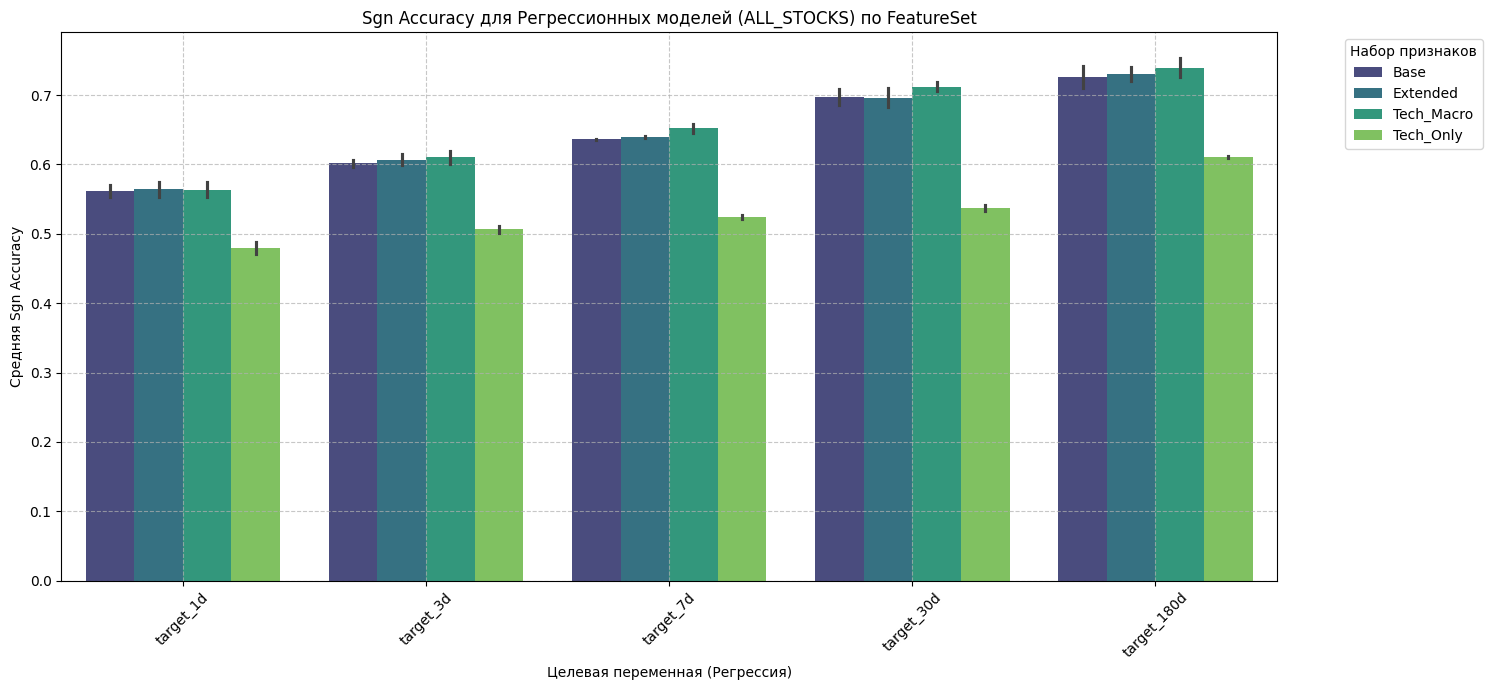

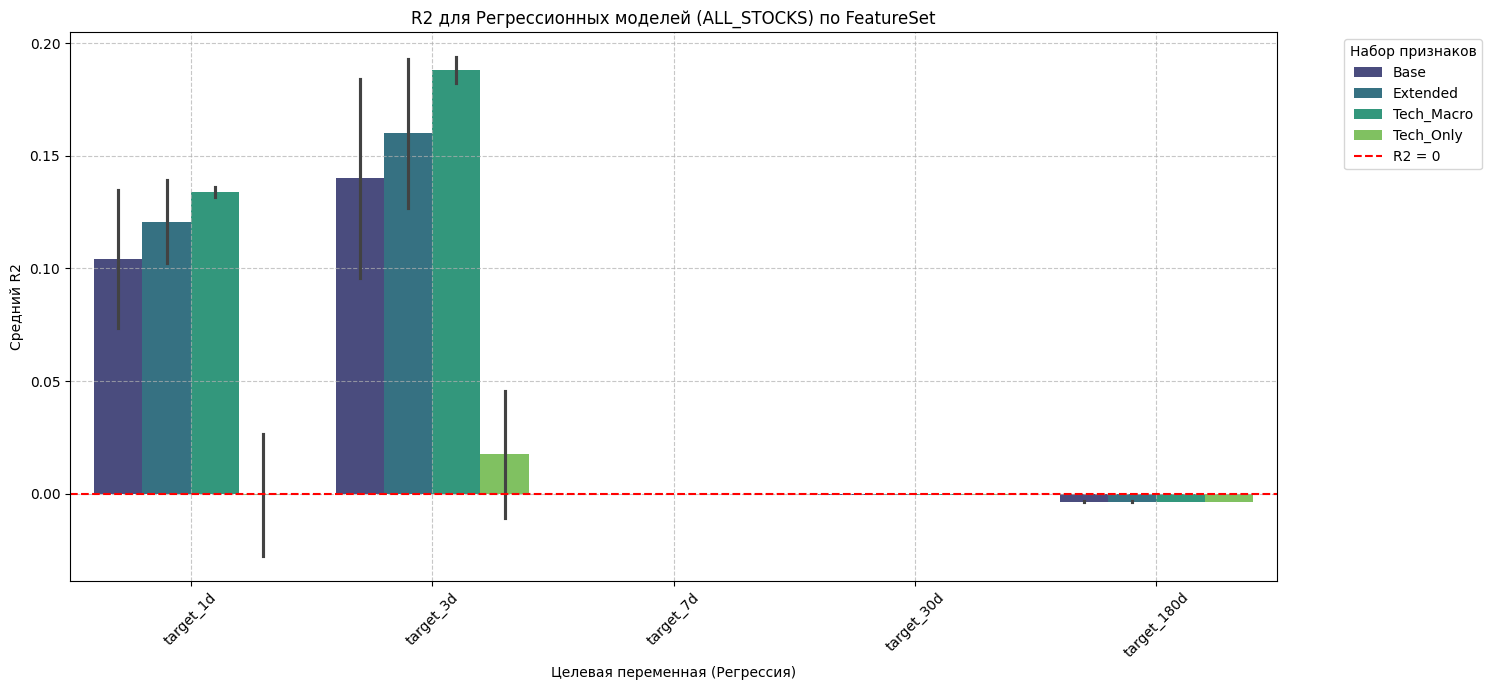


2. Классификационные модели для ALL_STOCKS:
Сводка метрик классификации (средние) для ALL_STOCKS:
                                              Accuracy        F1   ROC_AUC  \
TargetVariable     FeatureSet ModelType                                      
target_180d_binary Tech_Macro LGBMClassifier  0.801711  0.782234  0.888088   
                   Extended   LGBMClassifier  0.803655  0.787416  0.887330   
                   Base       LGBMClassifier  0.797008  0.779543  0.884184   
                   Tech_Macro XGBClassifier   0.790429  0.768351  0.878833   
                   Base       XGBClassifier   0.788242  0.768413  0.876721   
                   Extended   XGBClassifier   0.784146  0.764112  0.872634   
                   Tech_Only  LGBMClassifier  0.676080  0.652528  0.731111   
                              XGBClassifier   0.655876  0.633503  0.711823   
target_1d_binary   Extended   XGBClassifier   0.666239  0.542722  0.715603   
                              LGBMClassifie

<Figure size 1800x800 with 0 Axes>

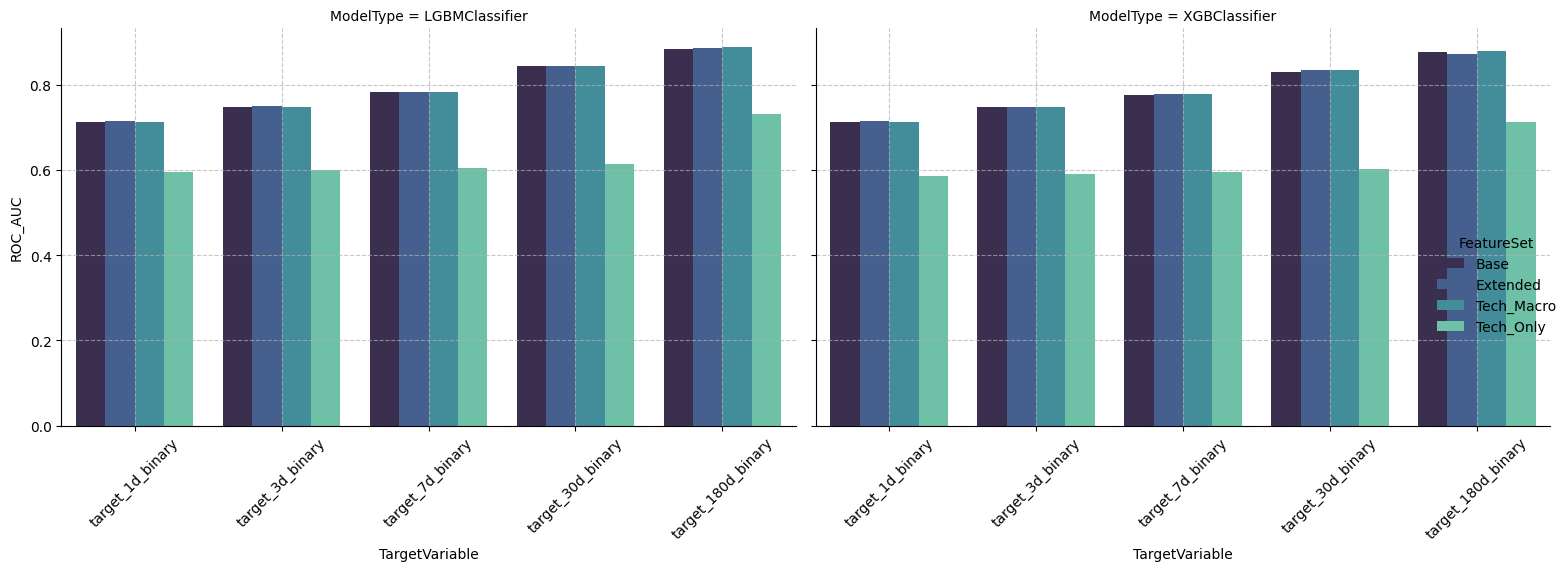


Сравнение влияния медиа-признаков (ROC_AUC): Base vs Extended (Классификация ALL_STOCKS)
Ошибка при создании pivot_table для Base vs Extended: "['ROC_AUC'] not in index"

Сравнение влияния различных наборов признаков (ROC_AUC) (Классификация ALL_STOCKS)
FeatureSet                             Base  Extended  Tech_Macro  Tech_Only
TargetVariable     ModelType                                                
target_180d_binary LGBMClassifier  0.884184  0.887330    0.888088   0.731111
                   XGBClassifier   0.876721  0.872634    0.878833   0.711823
target_1d_binary   LGBMClassifier  0.712466  0.714447    0.711928   0.594116
                   XGBClassifier   0.711616  0.715603    0.713473   0.586345
target_30d_binary  LGBMClassifier  0.844196  0.844998    0.843520   0.613912
                   XGBClassifier   0.829512  0.833653    0.834932   0.602936
target_3d_binary   LGBMClassifier  0.746695  0.750055    0.747669   0.599720
                   XGBClassifier   0.746782  0.74779

In [27]:
# Загрузка результатов
results_file = '../market_genius_model_results_v2.csv'
try:
    df_results = pd.read_csv(results_file)
    print(f"Файл '{results_file}' успешно загружен. Форма: {df_results.shape}")
except FileNotFoundError:
    print(f"ОШИБКА: Файл '{results_file}' не найден. Пожалуйста, убедитесь, что он находится в той же директории, что и ноутбук, или укажите правильный путь.")
    df_results = pd.DataFrame() # Создаем пустой DataFrame, чтобы избежать ошибок ниже

if not df_results.empty:
    # Преобразуем строковые значения ошибок/пропусков в метриках в NaN
    metric_cols = ['MAE', 'RMSE', 'R2', 'Sgn_acc', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
    for col in metric_cols:
        if col in df_results.columns:
            df_results[col] = pd.to_numeric(df_results[col], errors='coerce')

    print("\nПервые 5 строк загруженных результатов:")
    print(df_results.head())

    print("\nТипы данных в df_results:")
    df_results.info()

    # --- Быстрый взгляд на производительность по отдельным тикерам (SBER, ROSN) ---
    df_individual_tickers = df_results[df_results['Ticker'].isin(['SBER', 'ROSN'])]
    
    if not df_individual_tickers.empty:
        print("\n--- Средние метрики для ИНДИВИДУАЛЬНЫХ тикеров (SBER, ROSN) ---")
        
        # Регрессия для индивидуальных
        df_individual_reg = df_individual_tickers[df_individual_tickers['ModelType'].str.contains('Regressor')]
        if not df_individual_reg.empty:
            print("\nРегрессия (средние MAE, R2, Sgn_acc):")
            print(df_individual_reg.groupby(['Ticker', 'TargetVariable'])[['MAE', 'R2', 'Sgn_acc']].mean())
        else:
            print("\nНет данных по регрессии для индивидуальных тикеров.")

        # Классификация для индивидуальных
        df_individual_clf = df_individual_tickers[df_individual_tickers['ModelType'].str.contains('Classifier')]
        if not df_individual_clf.empty:
            print("\nКлассификация (средние F1, ROC_AUC):")
            # Для Precision, Recall, F1 часто бывают нули, особенно если один из классов не предсказан.
            # ROC_AUC может быть более стабильной метрикой для усреднения, если нет проблем с дисбалансом.
            print(df_individual_clf.groupby(['Ticker', 'TargetVariable'])[['F1', 'ROC_AUC', 'Accuracy']].mean())
        else:
            print("\nНет данных по классификации для индивидуальных тикеров.")
        print("-" * 50)
    else:
        print("\nНе найдено результатов для тикеров SBER или ROSN для отдельного анализа.")

    # --- Фокус на ALL_STOCKS ---
    df_all_stocks = df_results[df_results['Ticker'] == 'ALL_STOCKS'].copy() # Используем .copy() для избежания SettingWithCopyWarning
    
    if not df_all_stocks.empty:
        print("\n--- Анализ для ALL_STOCKS ---")
        print(f"Количество записей для ALL_STOCKS: {df_all_stocks.shape[0]}")

        # Разделим на регрессионные и классификационные для ALL_STOCKS
        df_all_stocks_reg = df_all_stocks[df_all_stocks['ModelType'].str.contains('Regressor')].copy()
        df_all_stocks_clf = df_all_stocks[df_all_stocks['ModelType'].str.contains('Classifier')].copy()

        # 1. Регрессионные модели для ALL_STOCKS
        if not df_all_stocks_reg.empty:
            print("\n1. Регрессионные модели для ALL_STOCKS:")
            print("Средние R2 и Sgn_acc по TargetVariable, FeatureSet, ModelType:")
            agg_reg_metrics = df_all_stocks_reg.groupby(['TargetVariable', 'FeatureSet', 'ModelType'])[['R2', 'Sgn_acc']].mean().sort_values(by=['TargetVariable', 'Sgn_acc'], ascending=[True, False])
            print(agg_reg_metrics)
            
            # Визуализация Sgn_acc для регрессии на ALL_STOCKS
            plt.figure(figsize=(15, 7))
            sns.barplot(data=df_all_stocks_reg, x='TargetVariable', y='Sgn_acc', hue='FeatureSet', palette='viridis')
            plt.title('Sgn Accuracy для Регрессионных моделей (ALL_STOCKS) по FeatureSet')
            plt.ylabel('Средняя Sgn Accuracy')
            plt.xlabel('Целевая переменная (Регрессия)')
            plt.xticks(rotation=45)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend(title='Набор признаков', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(15, 7))
            sns.barplot(data=df_all_stocks_reg, x='TargetVariable', y='R2', hue='FeatureSet', palette='viridis')
            plt.title('R2 для Регрессионных моделей (ALL_STOCKS) по FeatureSet')
            plt.ylabel('Средний R2')
            plt.xlabel('Целевая переменная (Регрессия)')
            plt.xticks(rotation=45)
            plt.axhline(0, color='red', linestyle='--', label='R2 = 0')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend(title='Набор признаков', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()
            
        else:
            print("Нет данных по регрессионным моделям для ALL_STOCKS.")

        # 2. Классификационные модели для ALL_STOCKS (как вы отметили, они более успешны)
        if not df_all_stocks_clf.empty:
            print("\n2. Классификационные модели для ALL_STOCKS:")
            # Сортируем по F1 или ROC_AUC для лучшего обзора
            clf_metrics_summary = df_all_stocks_clf.groupby(['TargetVariable', 'FeatureSet', 'ModelType'])[['Accuracy', 'F1', 'ROC_AUC', 'Precision', 'Recall']].mean().sort_values(by=['TargetVariable', 'ROC_AUC'], ascending=[True, False])
            print("Сводка метрик классификации (средние) для ALL_STOCKS:")
            with pd.option_context('display.max_rows', None): # Показать все строки для этой таблицы
                 print(clf_metrics_summary)

            # Визуализация для классификации (например, ROC AUC)
            primary_metric_clf = 'ROC_AUC' # Можно изменить на 'F1' или 'Accuracy'
            
            plt.figure(figsize=(18, 8)) # Увеличим размер для лучшей читаемости
            sns.catplot(data=df_all_stocks_clf, x='TargetVariable', y=primary_metric_clf, hue='FeatureSet', col='ModelType', kind='bar', palette='mako', height=6, aspect=1.2)
            # plt.suptitle(f'{primary_metric_clf} для Классификационных моделей (ALL_STOCKS)', y=1.03, fontsize=16) # catplot сам создает figure-level title
            # Общие настройки для всех subplots в catplot
            for ax in plt.gcf().axes: # plt.gcf() получает текущую фигуру
                 ax.tick_params(axis='x', rotation=45)
                 ax.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout(rect=[0, 0, 1, 0.97]) # rect для предотвращения перекрытия с suptitle (если бы он был)
            plt.show()

            # Сравнение Base vs Extended для классификации
            print(f"\nСравнение влияния медиа-признаков ({primary_metric_clf}): Base vs Extended (Классификация ALL_STOCKS)")
            df_base_ext_clf = df_all_stocks_clf[df_all_stocks_clf['FeatureSet'].isin(['Base', 'Extended'])]
            
            if not df_base_ext_clf.empty:
                try:
                    # pivot_table может вызвать ошибку, если есть NaN в index/columns/values после фильтрации
                    pivot_base_ext = df_base_ext_clf.pivot_table(index=['TargetVariable', 'ModelType'], 
                                                                columns='FeatureSet', 
                                                                values=primary_metric_clf)
                    if 'Base' in pivot_base_ext.columns and 'Extended' in pivot_base_ext.columns:
                        pivot_base_ext['Improvement_Extended_vs_Base'] = ((pivot_base_ext['Extended'] - pivot_base_ext['Base']) / pivot_base_ext['Base']) * 100
                        print(pivot_base_ext[[primary_metric_clf, 'Improvement_Extended_vs_Base']].sort_values(by='Improvement_Extended_vs_Base', ascending=False))
                    else:
                        print("Не удалось создать pivot table: отсутствуют колонки 'Base' или 'Extended' после фильтрации.")
                        print(pivot_base_ext)

                except Exception as e:
                    print(f"Ошибка при создании pivot_table для Base vs Extended: {e}")
            else:
                 print("Нет данных для сравнения Base vs Extended (классификация).")


            # Сравнение влияния удаления фундаментальных и макро признаков
            print(f"\nСравнение влияния различных наборов признаков ({primary_metric_clf}) (Классификация ALL_STOCKS)")
            # Tech_Macro vs Base
            # Tech_Only vs Tech_Macro
            
            # Для упрощения выведем таблицу сгруппированную по TargetVariable, ModelType, показывающую метрику для каждого FeatureSet
            pivot_all_features_clf = df_all_stocks_clf.pivot_table(index=['TargetVariable', 'ModelType'],
                                                                   columns='FeatureSet',
                                                                   values=primary_metric_clf)
            # Переупорядочим колонки для логичного сравнения
            ordered_feature_sets = [fs for fs in ['Base', 'Extended', 'Tech_Macro', 'Tech_Only'] if fs in pivot_all_features_clf.columns]
            print(pivot_all_features_clf[ordered_feature_sets])
            
        else:
            print("Нет данных по классификационным моделям для ALL_STOCKS.")
    else:
        print("Нет данных для ALL_STOCKS.")

else:
    print("DataFrame с результатами пуст. Анализ невозможен.")


In [47]:
# --- Подбор гиперпараметров для LGBMClassifier на ALL_STOCKS (X_extended_features) с использованием Optuna ---

# 1. Подготовка данных
target_clf_for_tuning = 'target_1d_binary' 
features_for_tuning = X_extended_features

if not all_stocks_df.empty and target_clf_for_tuning in all_stocks_df.columns:
    df_for_tuning = all_stocks_df.copy()

    # Убедимся, что все выбранные признаки существуют в df_for_tuning
    actual_features_for_tuning = [f for f in features_for_tuning if f in df_for_tuning.columns]
    if len(actual_features_for_tuning) < len(features_for_tuning):
        missing_features = set(features_for_tuning) - set(actual_features_for_tuning)
        print(f"Предупреждение: Следующие признаки из X_extended_features отсутствуют в all_stocks_df и не будут использованы: {missing_features}")

    if not actual_features_for_tuning:
        print("КРИТИЧЕСКОЕ ПРЕДУПРЕЖДЕНИЕ: Ни один из признаков X_extended_features не найден в all_stocks_df. Подбор гиперпараметров невозможен.")
    else:
        X_tune = df_for_tuning[actual_features_for_tuning]
        y_tune = df_for_tuning[target_clf_for_tuning]

        # Удаление строк с NaN в целевой переменной
        valid_indices_tune = y_tune.dropna().index
        X_tune = X_tune.loc[valid_indices_tune]
        y_tune = y_tune.loc[valid_indices_tune]

        if X_tune.empty or y_tune.empty or len(X_tune) < 20: # Увеличил минимальный порог для Optuna и TimeSeriesSplit
            print(f"Недостаточно данных (строк: {len(X_tune)}) после обработки NaN в таргете для подбора гиперпараметров. Требуется как минимум 20.")
        else:
            print(f"Данные для подбора гиперпараметров LGBMClassifier подготовлены. X_tune: {X_tune.shape}, y_tune: {y_tune.shape}")
            print(f"Целевая переменная: {target_clf_for_tuning}")
            print(f"Количество используемых признаков: {len(actual_features_for_tuning)}")

            # 2. Определение функции objective для Optuna
            def objective(trial):
                # Определяем пространства поиска гиперпараметров
                params = {
                    'objective': 'binary',
                    'metric': 'auc',
                    'verbosity': -1,
                    'boosting_type': 'gbdt',
                    'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
                    'num_leaves': trial.suggest_int('num_leaves', 20, 100, step=5),
                    'max_depth': trial.suggest_int('max_depth', 3, 12),
                    'min_child_samples': trial.suggest_int('min_child_samples', 5, 50, step=5),
                    'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.1),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0, step=0.1),
                    'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True), # L1 regularization
                    'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True), # L2 regularization
                    'random_state': 42,
                    'n_jobs': -1
                }

                # Кросс-валидация с TimeSeriesSplit
                # Убедимся, что данных достаточно для n_splits
                n_splits_cv = 5
                if len(X_tune) < n_splits_cv + 1 :
                    print(f"Данных ({len(X_tune)}) недостаточно для {n_splits_cv} фолдов TimeSeriesSplit. Уменьшаю n_splits до максимально возможного.")
                    n_splits_cv = max(2, len(X_tune) // 2) # хотя бы 2 фолда, если возможно

                tscv = TimeSeriesSplit(n_splits=n_splits_cv)
                roc_auc_scores = []

                for train_index, val_index in tscv.split(X_tune, y_tune):
                    X_train_fold, X_val_fold = X_tune.iloc[train_index], X_tune.iloc[val_index]
                    y_train_fold, y_val_fold = y_tune.iloc[train_index], y_tune.iloc[val_index]

                    if len(X_train_fold) == 0 or len(X_val_fold) == 0:
                        # print("Пропуск фолда из-за пустого train/validation набора.")
                        continue
                    if len(np.unique(y_train_fold)) < 2 or len(np.unique(y_val_fold)) < 2:
                        # print("Пропуск фолда из-за одного класса в y_train_fold или y_val_fold")
                        continue # Пропускаем фолд, если в нем только один класс

                    model = LGBMClassifier(**params)
                    try:
                        model.fit(X_train_fold, y_train_fold,
                                    eval_set=[(X_val_fold, y_val_fold)],
                                    eval_metric='auc',
                                    callbacks=[optuna.integration.LightGBMPruningCallback(trial, 'auc')])

                        preds_proba = model.predict_proba(X_val_fold)[:, 1]
                        roc_auc_scores.append(roc_auc_score(y_val_fold, preds_proba))
                    except Exception as e:
                        # print(f"Ошибка во время обучения или предсказания на фолде: {e}")
                        roc_auc_scores.append(0.0) # или np.nan, но Optuna ожидает float

                return np.mean(roc_auc_scores) if roc_auc_scores else 0.0

            # 3. Запуск оптимизации Optuna
            study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
            print(f"Начинаем подбор гиперпараметров (Optuna)...")
            study.optimize(objective, n_trials=50, timeout=1800) # 50 попыток или 30 минут

            print("\\n--- Результаты подбора гиперпараметров Optuna ---")
            print(f"Лучшее значение ROC AUC на кросс-валидации: {study.best_value:.4f}")
            print("Лучшие гиперпараметры:")
            best_lgbm_params = study.best_params
            for key, value in best_lgbm_params.items():
                print(f"  {key}: {value}")

            # Дополняем параметры, не участвовавшие в подборе
            best_lgbm_params['objective'] = 'binary'
            best_lgbm_params['metric'] = 'auc'
            best_lgbm_params['verbosity'] = -1
            best_lgbm_params['random_state'] = 42
            best_lgbm_params['n_jobs'] = -1

            # 4. Обучение и оценка лучшей модели LGBMClassifier на последнем фолде TimeSeriesSplit
            print("\\n--- Обучение и оценка LGBMClassifier с лучшими гиперпараметрами на тестовом наборе ---")

            final_tscv_eval = TimeSeriesSplit(n_splits=5)
            all_final_splits_eval = list(final_tscv_eval.split(X_tune, y_tune))
            train_final_idx_eval, test_final_idx_eval = all_final_splits_eval[-1]

            X_train_final_eval, X_test_final_eval = X_tune.iloc[train_final_idx_eval], X_tune.iloc[test_final_idx_eval]
            y_train_final_eval, y_test_final_eval = y_tune.iloc[train_final_idx_eval], y_tune.iloc[test_final_idx_eval]

            if len(X_train_final_eval) == 0 or len(X_test_final_eval) == 0:
                print("Ошибка: Пустой train или test набор для финальной оценки.")
            elif len(np.unique(y_train_final_eval)) < 2 or len(np.unique(y_test_final_eval)) < 2:
                print("Ошибка: Один класс в y_train_final_eval или y_test_final_eval для финальной оценки.")
            else:
                print(f"Размер финального обучающего набора: {X_train_final_eval.shape}, тестового: {X_test_final_eval.shape}")

                final_lgbm_model = LGBMClassifier(**best_lgbm_params)
                final_lgbm_model.fit(X_train_final_eval, y_train_final_eval)
                y_pred_final_eval = final_lgbm_model.predict(X_test_final_eval)
                y_pred_proba_final_eval = final_lgbm_model.predict_proba(X_test_final_eval)[:, 1]

                print("Метрики на тестовом наборе с лучшими гиперпараметрами:")
                print(f"  Accuracy: {accuracy_score(y_test_final_eval, y_pred_final_eval):.4f}")
                print(f"  Precision: {precision_score(y_test_final_eval, y_pred_final_eval, zero_division=0):.4f}")
                print(f"  Recall: {recall_score(y_test_final_eval, y_pred_final_eval, zero_division=0):.4f}")
                print(f"  F1 Score: {f1_score(y_test_final_eval, y_pred_final_eval, zero_division=0):.4f}")
                print(f"  ROC AUC: {roc_auc_score(y_test_final_eval, y_pred_proba_final_eval):.4f}")

                # Отображение важности признаков для лучшей модели
                # import matplotlib.pyplot as plt
                # import seaborn as sns
                # print("\\nОтображение важности признаков...")
                # feature_importances = pd.Series(final_lgbm_model.feature_importances_, index=X_tune.columns)
                # plt.figure(figsize=(10, max(10, len(X_tune.columns)//4))) # Динамический размер для большого кол-ва признаков
                # sns.barplot(x=feature_importances.sort_values(ascending=False).head(30),
                #             y=feature_importances.sort_values(ascending=False).head(30).index)
                # plt.title('Топ-30 Важных признаков (LGBMClassifier с Optuna)')
                # plt.xlabel('Важность')
                # plt.ylabel('Признак')
                # plt.tight_layout()
                # plt.show()

else:
    print("Не удалось загрузить all_stocks_df или отсутствует целевая колонка для подбора гиперпараметров.")

print("\\nПодбор гиперпараметров завершен.")

[I 2025-05-28 15:05:14,222] A new study created in memory with name: no-name-d078742c-8760-4c66-b396-7c3373d73412


Данные для подбора гиперпараметров LGBMClassifier подготовлены. X_tune: (346177, 132), y_tune: (346177,)
Целевая переменная: target_1d_binary
Количество используемых признаков: 132
Начинаем подбор гиперпараметров (Optuna)...


[I 2025-05-28 15:05:14,714] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 900, 'learning_rate': 0.03634446643805034, 'num_leaves': 60, 'max_depth': 3, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.9, 'reg_alpha': 1.9152584521132006e-06, 'reg_lambda': 1.5666922059058115e-06}. Best is trial 0 with value: 0.0.
[I 2025-05-28 15:05:15,255] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 700, 'learning_rate': 0.03317669586066066, 'num_leaves': 50, 'max_depth': 10, 'min_child_samples': 25, 'subsample': 0.9, 'colsample_bytree': 0.7, 'reg_alpha': 1.2333592219953676e-06, 'reg_lambda': 0.0006095385171334596}. Best is trial 0 with value: 0.0.
[I 2025-05-28 15:05:15,783] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 400, 'learning_rate': 0.011989266886949906, 'num_leaves': 60, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_alpha': 0.16571157040597398, 'reg_lambda': 3.65766334198766

\n--- Результаты подбора гиперпараметров Optuna ---
Лучшее значение ROC AUC на кросс-валидации: 0.0000
Лучшие гиперпараметры:
  n_estimators: 900
  learning_rate: 0.03634446643805034
  num_leaves: 60
  max_depth: 3
  min_child_samples: 20
  subsample: 0.6
  colsample_bytree: 0.9
  reg_alpha: 1.9152584521132006e-06
  reg_lambda: 1.5666922059058115e-06
\n--- Обучение и оценка LGBMClassifier с лучшими гиперпараметрами на тестовом наборе ---
Размер финального обучающего набора: (288481, 132), тестового: (57696, 132)
Метрики на тестовом наборе с лучшими гиперпараметрами:
  Accuracy: 0.6498
  Precision: 0.6551
  Recall: 0.3435
  F1 Score: 0.4507
  ROC AUC: 0.6954
\nПодбор гиперпараметров завершен.


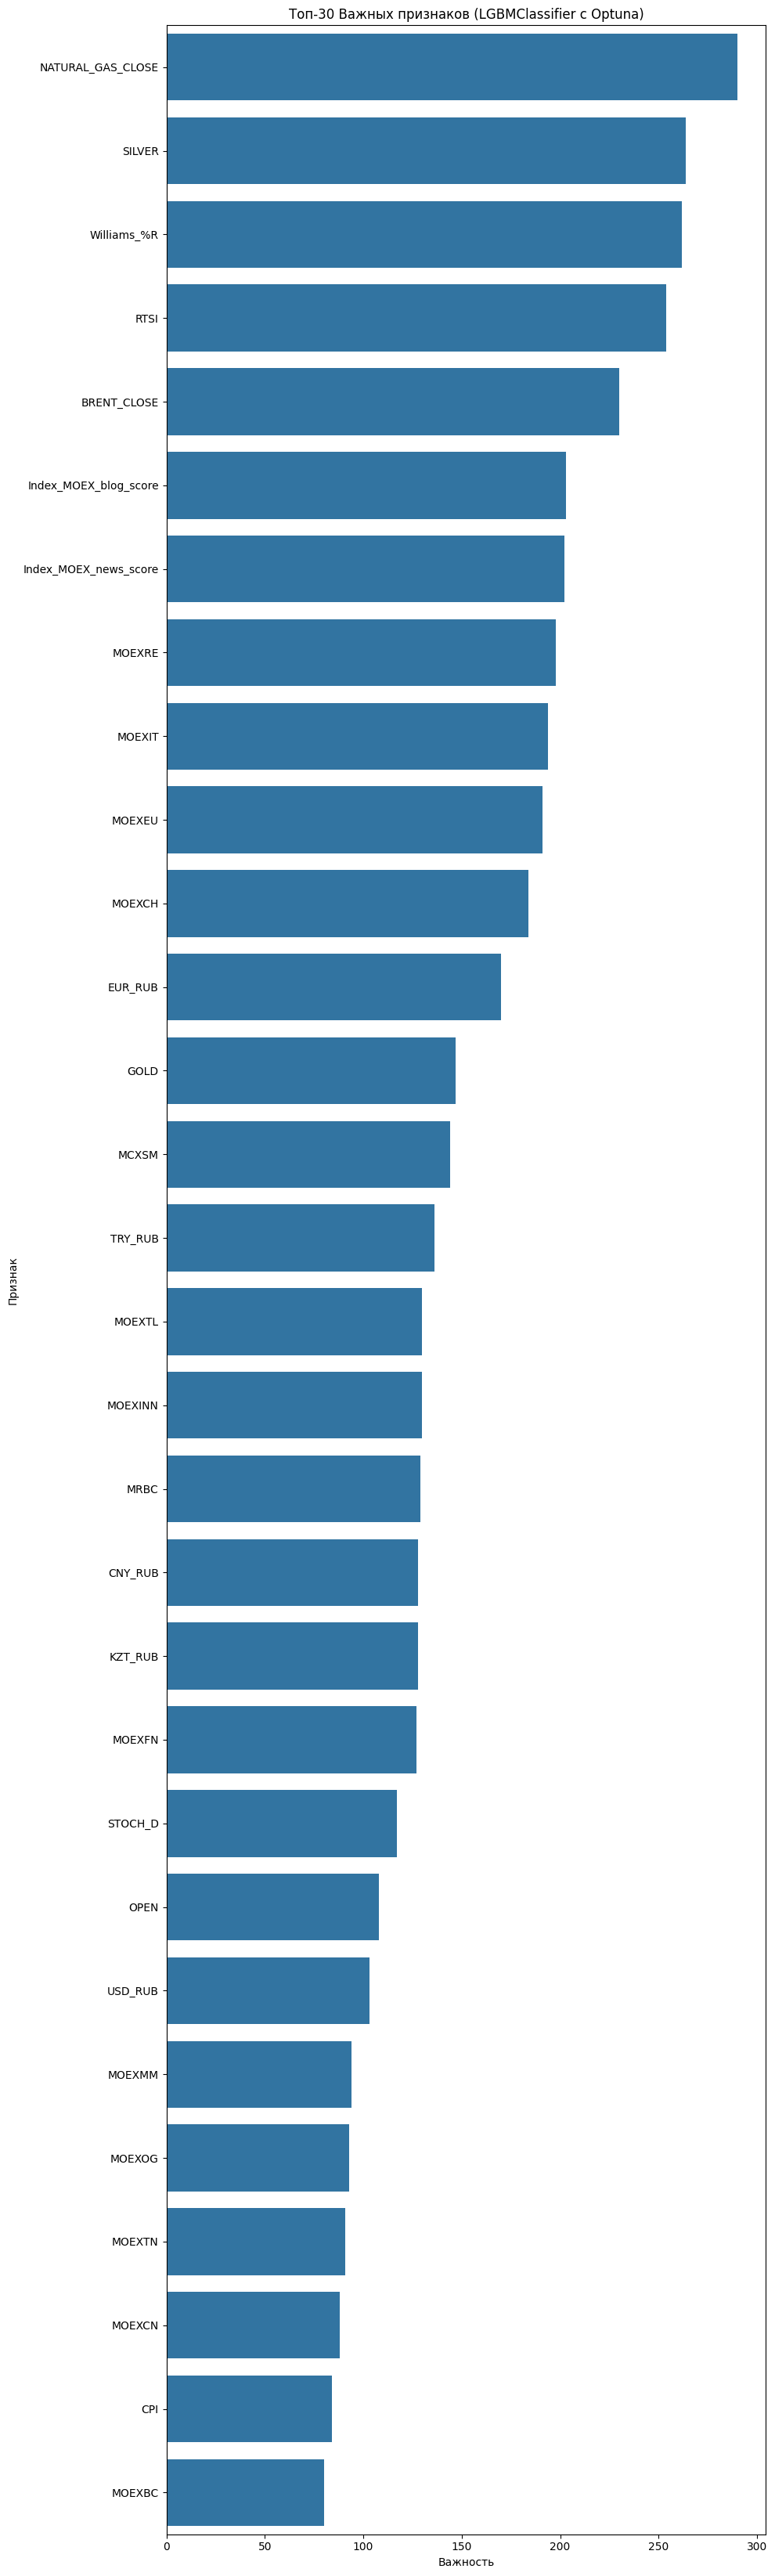

In [48]:
feature_importances = pd.Series(final_lgbm_model.feature_importances_, index=X_tune.columns)
plt.figure(figsize=(10, max(10, len(X_tune.columns)//4))) # Динамический размер для большого кол-ва признаков
sns.barplot(x=feature_importances.sort_values(ascending=False).head(30),
            y=feature_importances.sort_values(ascending=False).head(30).index)
plt.title('Топ-30 Важных признаков (LGBMClassifier с Optuna)')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()